In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.mode.use_inf_as_na = True

In [2]:
wine = pd.read_csv('wine_quality.csv')
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [3]:
wine[wine.isna()].count()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

##### no missing values detected

### Checking for outliers

In [4]:
from scipy import stats
from scipy.stats import zscore

In [5]:
z_scores = stats.zscore(wine)

#Identifying points that are three standard deviations away
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

#Creating new datframe with with the filtered values
wine_new = wine[filtered_entries]

In [6]:
#Identifying number of rows in new dataframe with the filtered values
wine_new_rows = len(wine_new)

#Number of rows in the original dataframes
wine_rows = len(wine.index)

#Reduction in the rows of the dataset
wine_reduction = wine_rows-wine_new_rows
wine_reduction_percent = (wine_reduction/wine_rows)*100

print(wine_reduction,"outliers have been removed from the wine_red dataset, which represents", round(wine_reduction_percent,2),"% of the original dataset." )

148 outliers have been removed from the wine_red dataset, which represents 9.26 % of the original dataset.


### Exploratory Data Analysis

<Axes: >

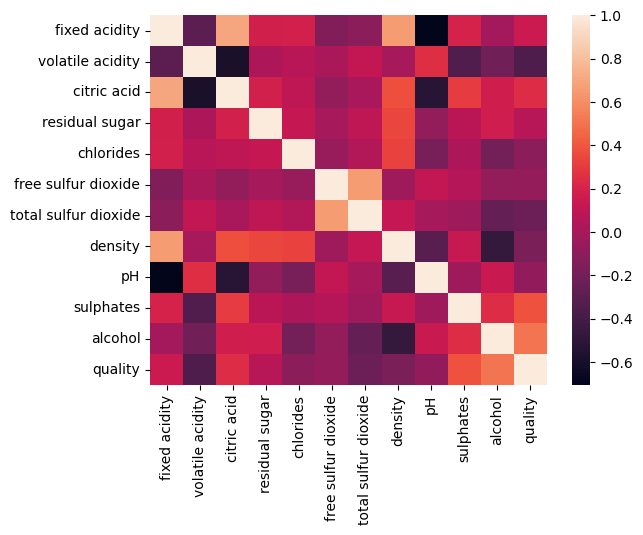

In [7]:
sns.heatmap(wine_new.corr())

#### It appears that free sulphur dioxide values appear to be most correlated with quality.

### Train Test Split 

In [8]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split

ss_scores = StandardScaler().fit_transform(wine.drop(columns={"quality"},axis=1))
wine_ss = pd.DataFrame(np.vstack((ss_scores.T,wine.quality)).T,columns=wine.columns)
x = wine_ss.drop(columns={"quality"},axis=1)
y = wine_ss["quality"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.07,random_state=42)

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score

compare_model = []

#Creating a dictionary called param_grid and fill out some parameters for C and gamma
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

#Create a GridSearchCV object and fit it to the training data
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2).fit(x_train,y_train)
grid_predictions = grid.predict(x_test)

compare_model = pd.Series(['SVM',accuracy_score(y_test,grid_predictions),
                          precision_score(y_test,grid_predictions,average='weighted'),
                            recall_score(y_test,grid_predictions,average='weighted'),
                          f1_score(y_test,grid_predictions,average='weighted')])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1

C:\Users\rodst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.tree import DecisionTreeClassifier

#Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data
dtree = DecisionTreeClassifier()
dtree.fit(x_train,y_train)
dt_predictions = dtree.predict(x_test)

compare_model = pd.concat([compare_model,pd.Series(['Decision Trees',
                            accuracy_score(y_test,dt_predictions),
                          precision_score(y_test,dt_predictions,average='weighted'),
                            recall_score(y_test,dt_predictions,average='weighted'),
                          f1_score(y_test,dt_predictions,average='weighted')])],axis=1)

C:\Users\rodst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
from sklearn.ensemble import RandomForestClassifier

#Create an instance of the RandomForestClassifier class and fit it to our training data
#n_estimators is the number of trees in the forest
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train,y_train)
rf_predictions = rfc.predict(x_test)

compare_model = pd.concat([compare_model,pd.Series(['Random Forests',
                            accuracy_score(y_test,rf_predictions),
                          precision_score(y_test,rf_predictions,average='weighted'),
                            recall_score(y_test,rf_predictions,average='weighted'),
                          f1_score(y_test,rf_predictions,average='weighted')])],axis=1)

C:\Users\rodst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

linear_model = LinearRegression().fit(x_train,y_train)
lnr_predictions = linear_model.predict(x_test)
lnr_predictions = np.round(lnr_predictions).astype('int')

compare_model = pd.concat([compare_model,pd.Series(['Linear Regression',
                                    accuracy_score(y_test,lnr_predictions),
                          precision_score(y_test,lnr_predictions,average='weighted'),
                            recall_score(y_test,lnr_predictions,average='weighted'),
                          f1_score(y_test,lnr_predictions,average='weighted')])],axis=1)

C:\Users\rodst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# linear coefficients
pd.DataFrame(np.vstack((x.columns,linear_model.coef_)).T,columns=["Factors","Coefficients"])

,Factors,Coefficients
0,fixed acidity,0.050433
1,volatile acidity,-0.187009
2,citric acid,-0.029302
3,residual sugar,0.021979
4,chlorides,-0.085265
5,free sulfur dioxide,0.0471
6,total sulfur dioxide,-0.109137
7,density,-0.038981
8,pH,-0.055303
9,sulphates,0.150315


In [14]:
log_model = LogisticRegression(solver='liblinear').fit(x_train,y_train)
lgr_predictions = log_model.predict(x_test)

compare_model = pd.concat([compare_model,pd.Series(['Logistic Regression',
                                    accuracy_score(y_test,lgr_predictions),
                          precision_score(y_test,lgr_predictions,average='weighted'),
                            recall_score(y_test,lgr_predictions,average='weighted'),
                          f1_score(y_test,lgr_predictions,average='weighted')])],axis=1)

C:\Users\rodst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model = pd.DataFrame(compare_model).T
model.columns = ['Model','Accuracy','Precision','Recall','F1 Score']
model.round(2).sort_values(by=['Accuracy'],ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
0,SVM,0.669643,0.630631,0.669643,0.640175
0,Random Forests,0.660714,0.615476,0.660714,0.634016
1,Decision Trees,0.633929,0.64517,0.633929,0.635984
0,Logistic Regression,0.616071,0.543283,0.616071,0.572211
0,Linear Regression,0.580357,0.504464,0.580357,0.535895


Text(0.5, 1.0, 'Actual v Expected values')

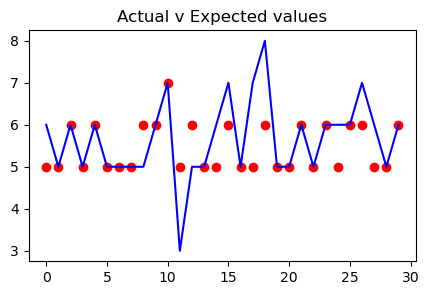

In [16]:
# best model: SVM
plt.figure(figsize=(5,3))
ax = range(len(grid_predictions[0:30]))
plt.plot(ax,y_test[0:30],color="b",label="actual")
plt.scatter(ax,grid_predictions[0:30],color="r",label="expected")
plt.title("Actual v Expected values")

##### Best Scaler: Standard Scaler()
##### Best Feature Selection: Variance Threshold
##### Best Model: Random Forest